In [12]:
using CobraTools
using JuMP
using Gurobi # use your favourite solver
using Measurements
using LinearAlgebra
using JLD
using Plots
pyplot()

Plots.PyPlotBackend()

### Import model

In [13]:
# E. coli model
modelpath = joinpath("..", "models", "iJO1366.json") 
model = CobraTools.read_model(modelpath)
# gibbs = CobraTools.mapGibbs(model.rxns) # very slow - rather just import this - will need to reload for other models

## issue
decomp = JLD.load(joinpath("..","data", "dgzeros.jld"), "gibbs")
gibbs = Dict{String, Measurement{Float64}}()
for (k, vs) in decomp
    gibbs[k] = vs[1] ± vs[2]
end
##

ecoli_kJmolCarbon = -37.36 ± 8.55 # formation of biomass kJ/mol 74.36 ± 8.67
model

Constraint based model: iJO1366
Number of reactions: 2583
Number of metabolites: 1805
Number of genes: 1367


In [18]:
cbmodel, v, mb, ubs, lbs = CobraTools.CBM(model);
set_optimizer(cbmodel, Gurobi.Optimizer)
set_optimizer_attribute(cbmodel, "OutputFlag", 0) # quiet

biomass_index = model[findfirst(model.rxns, "BIOMASS_Ec_iJO1366_WT_53p95M")] 
glucose_index = model[findfirst(model.rxns, "EX_glc__D_e")]
o2_index = model[findfirst(model.rxns, "EX_o2_e")]
atpm_index = model[findfirst(model.rxns, "ATPM")]

Academic license - for non-commercial use only - expires 2021-03-27


716

In [19]:
# Fix glucose use 1.0 then normalization is easy. NB - if not 1 then change normalization!!
CobraTools.set_bound(glucose_index, ubs, lbs; ub=-1.0, lb=-1.0)

# Aerobic
CobraTools.set_bound(o2_index, ubs, lbs; ub=1000.0, lb=-1000.0)
# Anaerobic
# CobraTools.set_bound(o2_index, ubs, lbs; ub=1000.0, lb=0.0)

# No free ATP generation
CobraTools.set_bound(atpm_index, ubs, lbs; ub=1000.0, lb=0.0)

@objective(cbmodel, Max, v[biomass_index])

optimize!(cbmodel) 
termination_status(cbmodel) != MOI.OPTIMAL && @warn "Optimization issue..."

μ_max = objective_value(cbmodel)

0.0999636270368222

In [20]:
μs = range(0.0, μ_max, length=20)
ΔG_exts = Measurement{Float64}[]
ΔG_ints = Measurement{Float64}[]
missing_exts = Float64[]
missing_ints = Float64[]

for μ in μs
    ### No atpm production
    CobraTools.set_bound(atpm_index, ubs, lbs; ub=1000.0, lb=0.0)

    ### Fix biomass
    CobraTools.set_bound(biomass_index, ubs, lbs; ub=μ, lb=0.99*μ)
    
    @objective(cbmodel, Max, v[atpm_index]) # maximum catabolism
    optimize!(cbmodel)
    termination_status(cbmodel) != MOI.OPTIMAL && @warn "Catabolic optimization issue at $μ"
    
    λ = objective_value(cbmodel) # maximum ATP burnt
    
    ### Fix ATP burn rate
    CobraTools.set_bound(atpm_index, ubs, lbs; ub=λ, lb=λ*0.99)
    
    @objective(cbmodel, Min, dot(v,v)) # parsimonious
    optimize!(cbmodel)
    termination_status(cbmodel) != MOI.OPTIMAL && @warn "Parsimonious optimization issue at μ=$(round(μ, digits=3)) with $(termination_status(cbmodel))"
    
    fluxes = CobraTools.map_fluxes(v, model)
    carbon_ex = CobraTools.atom_exchange(fluxes, model)["C"] # carbon flux

    ΔG_ext, missing_ext =  CobraTools.map_gibbs_external(fluxes, gibbs) 
    ΔG_int, missing_int =  CobraTools.map_gibbs_internal(fluxes, gibbs)
    
    ΔG_int -= carbon_ex*ecoli_kJmolCarbon # minus because carbons consumed
    ΔG_ext -= carbon_ex*ecoli_kJmolCarbon # minus because carbons consumed
    
    push!(ΔG_exts, ΔG_ext)
    push!(ΔG_ints, ΔG_int)
    push!(missing_exts, missing_ext)
    push!(missing_ints, missing_int)
end

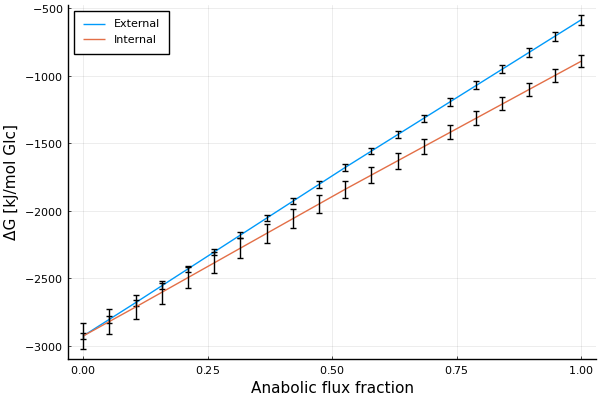

In [21]:
plot(μs./μ_max, ΔG_exts, label="External", ylabel="ΔG [kJ/mol Glc]", xlabel="Anabolic flux fraction")
plot!(μs./μ_max, ΔG_ints, label="Internal", ylabel="ΔG [kJ/mol Glc]", xlabel="Anabolic flux fraction")
# savefig("aerobic_dg.png")

In [7]:
# [missing_exts missing_ints]